In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import string
import unicodedata
from io import open
import glob
import os
import time
import random
import numpy as np
from typing import List, Tuple, Set, Optional, Dict
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy.typing as npt

# Device setup
device: torch.device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [13]:
allowed_characters: str = string.ascii_letters + " .,;'" + "_"
n_letters: int = len(allowed_characters)


def unicodeToAscii(s: str) -> str:
    """Convert Unicode string to ASCII, filtering allowed characters."""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )


def letterToIndex(letter: str) -> int:
    """Find letter index from allowed_characters."""
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)


def lineToTensor(line: str) -> torch.Tensor:
    """Turn a line into a <line_length x 1 x n_letters> tensor."""
    tensor: torch.Tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [14]:
class NamesDataset(Dataset):
    """Dataset for loading names from text files organized by language/origin."""

    def __init__(self, data_dir: str) -> None:
        self.data_dir: str = data_dir
        self.load_time: time.struct_time = time.localtime()
        labels_set: Set[str] = set()

        self.data: List[str] = []
        self.data_tensors: List[torch.Tensor] = []
        self.labels: List[str] = []
        self.labels_tensors: List[torch.Tensor] = []

        text_files: List[str] = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label: str = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines: List[str] = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        self.labels_uniq: List[str] = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor: torch.Tensor = torch.tensor(
                [self.labels_uniq.index(self.labels[idx])],
                dtype=torch.long
            )
            self.labels_tensors.append(temp_tensor)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, str, str]:
        data_item: str = self.data[idx]
        data_label: str = self.labels[idx]
        data_tensor: torch.Tensor = self.data_tensors[idx]
        label_tensor: torch.Tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [15]:
# ===============================
# IMPROVED MODEL ARCHITECTURES
# ===============================

class CharRNN(nn.Module):
    """Basic Character-level RNN for name classification."""

    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        super(CharRNN, self).__init__()

        self.rnn: nn.RNN = nn.RNN(input_size, hidden_size)
        self.h2o: nn.Linear = nn.Linear(hidden_size, output_size)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor: torch.Tensor) -> torch.Tensor:
        rnn_out: torch.Tensor
        hidden: torch.Tensor
        rnn_out, hidden = self.rnn(line_tensor)
        output: torch.Tensor = self.h2o(hidden[0])
        output = self.softmax(output)

        return output


class CharLSTM(nn.Module):
    """Character-level LSTM for name classification."""

    def __init__(self, input_size: int, hidden_size: int, output_size: int, dropout: float = 0.1) -> None:
        super(CharLSTM, self).__init__()

        self.lstm: nn.LSTM = nn.LSTM(input_size, hidden_size, batch_first=False)
        self.dropout: nn.Dropout = nn.Dropout(dropout)
        self.h2o: nn.Linear = nn.Linear(hidden_size, output_size)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor: torch.Tensor) -> torch.Tensor:
        lstm_out: torch.Tensor
        hidden: Tuple[torch.Tensor, torch.Tensor]
        lstm_out, hidden = self.lstm(line_tensor)
        output: torch.Tensor = self.dropout(hidden[0][0])
        output = self.h2o(output)
        output = self.softmax(output)

        return output


class CharGRU(nn.Module):
    """Character-level GRU for name classification."""

    def __init__(self, input_size: int, hidden_size: int, output_size: int, dropout: float = 0.1) -> None:
        super(CharGRU, self).__init__()

        self.gru: nn.GRU = nn.GRU(input_size, hidden_size, batch_first=False)
        self.dropout: nn.Dropout = nn.Dropout(dropout)
        self.h2o: nn.Linear = nn.Linear(hidden_size, output_size)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor: torch.Tensor) -> torch.Tensor:
        gru_out: torch.Tensor
        hidden: torch.Tensor
        gru_out, hidden = self.gru(line_tensor)
        output: torch.Tensor = self.dropout(hidden[0])
        output = self.h2o(output)
        output = self.softmax(output)

        return output


class DeepCharRNN(nn.Module):
    """Deep Character-level RNN with multiple layers."""

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        n_layers: int = 2,
        dropout: float = 0.2
    ) -> None:
        super(DeepCharRNN, self).__init__()

        self.rnn: nn.RNN = nn.RNN(input_size, hidden_size, num_layers=n_layers, dropout=dropout)
        self.dropout: nn.Dropout = nn.Dropout(dropout)
        self.h2hidden: nn.Linear = nn.Linear(hidden_size, hidden_size // 2)
        self.hidden2o: nn.Linear = nn.Linear(hidden_size // 2, output_size)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor: torch.Tensor) -> torch.Tensor:
        rnn_out: torch.Tensor
        hidden: torch.Tensor
        rnn_out, hidden = self.rnn(line_tensor)
        output: torch.Tensor = self.dropout(hidden[-1])
        output = F.relu(self.h2hidden(output))
        output = self.hidden2o(output)
        output = self.softmax(output)

        return output


class BiDirectionalCharLSTM(nn.Module):
    """Bidirectional LSTM for better context understanding."""

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        dropout: float = 0.2
    ) -> None:
        super(BiDirectionalCharLSTM, self).__init__()

        self.lstm: nn.LSTM = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=False,
            bidirectional=True
        )
        self.dropout: nn.Dropout = nn.Dropout(dropout)
        self.h2o: nn.Linear = nn.Linear(hidden_size * 2, output_size)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor: torch.Tensor) -> torch.Tensor:
        lstm_out: torch.Tensor
        hidden: Tuple[torch.Tensor, torch.Tensor]
        lstm_out, hidden = self.lstm(line_tensor)
        # Concatenate forward and backward hidden states
        output: torch.Tensor = torch.cat((hidden[0][0], hidden[0][1]), dim=1)
        output = self.dropout(output)
        output = self.h2o(output)
        output = self.softmax(output)

        return output

In [16]:
# ===============================
# TRAINING UTILITIES
# ===============================

def label_from_output(output: torch.Tensor, output_labels: List[str]) -> Tuple[str, int]:
    """Extract the most likely label from model output."""
    top_n: torch.Tensor
    top_i: torch.Tensor
    top_n, top_i = output.topk(1)
    label_i: int = top_i[0].item()
    return output_labels[label_i], label_i


def train(
    rnn: nn.Module,
    training_data: torch.utils.data.Subset,
    n_epoch: int = 10,
    n_batch_size: int = 64,
    report_every: int = 50,
    learning_rate: float = 0.2,
    criterion: nn.Module = nn.NLLLoss()
) -> List[float]:
    """Train the model with specified hyperparameters."""
    current_loss: float = 0.0
    all_losses: List[float] = []
    rnn.train()
    optimizer: torch.optim.SGD = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start: float = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad()

        # Create minibatches
        batches_indices: List[int] = list(range(len(training_data)))
        random.shuffle(batches_indices)
        batches: List[npt.NDArray[np.int_]] = np.array_split(
            batches_indices,
            len(batches_indices) // n_batch_size
        )

        for idx, batch in enumerate(batches):
            batch_loss: torch.Tensor = torch.tensor(0.0)
            for i in batch:
                label_tensor: torch.Tensor
                text_tensor: torch.Tensor
                label: str
                text: str
                (label_tensor, text_tensor, label, text) = training_data[i]
                output: torch.Tensor = rnn.forward(text_tensor)
                loss: torch.Tensor = criterion(output, label_tensor)
                batch_loss += loss

            # Optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 5)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches))
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]:.4f}")
        current_loss = 0.0

    return all_losses

In [17]:
def evaluate(rnn: nn.Module, testing_data: torch.utils.data.Subset, classes: List[str]) -> Dict[str, float]:
    """Evaluate the model and return metrics."""
    confusion: torch.Tensor = torch.zeros(len(classes), len(classes))

    rnn.eval()
    correct: int = 0
    total: int = 0

    with torch.no_grad():
        for i in range(len(testing_data)):
            label_tensor: torch.Tensor
            text_tensor: torch.Tensor
            label: str
            text: str
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output: torch.Tensor = rnn(text_tensor)
            guess: str
            guess_i: int
            guess, guess_i = label_from_output(output, classes)
            label_i: int = classes.index(label)
            confusion[label_i][guess_i] += 1

            if guess == label:
                correct += 1
            total += 1

    # Calculate accuracy
    accuracy: float = correct / total

    # Normalize confusion matrix
    for i in range(len(classes)):
        denom: torch.Tensor = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Plot confusion matrix
    fig: plt.Figure = plt.figure(figsize=(12, 10))
    ax: plt.Axes = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy(), cmap='Blues')
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2%})')
    plt.tight_layout()
    plt.show()
    plt.close(fig)

    return {
        'accuracy': accuracy,
        'confusion': confusion
    }

In [18]:
def run_experiment(
    model_name: str,
    model: nn.Module,
    train_set: torch.utils.data.Subset,
    test_set: torch.utils.data.Subset,
    classes: List[str],
    n_epoch: int = 30,
    learning_rate: float = 0.15,
    batch_size: int = 64
) -> Dict[str, any]:
    """Run a complete training and evaluation experiment."""
    print(f"\n{'='*60}")
    print(f"Experiment: {model_name}")
    print(f"{'='*60}")

    start: float = time.time()
    all_losses: List[float] = train(
        model,
        train_set,
        n_epoch=n_epoch,
        learning_rate=learning_rate,
        n_batch_size=batch_size,
        report_every=5
    )
    end: float = time.time()

    print(f"Training took {end-start:.2f}s")

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(all_losses)
    plt.title(f'{model_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    plt.close()

    # Evaluate
    print(f"\nEvaluating {model_name}...")
    metrics: Dict[str, float] = evaluate(model, test_set, classes)
    print(f"Test Accuracy: {metrics['accuracy']:.2%}")

    return {
        'model_name': model_name,
        'losses': all_losses,
        'metrics': metrics,
        'training_time': end - start
    }

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# ===============================
# MAIN EXPERIMENTS
# ===============================

# Load data
alldata: NamesDataset = NamesDataset("/content/drive/MyDrive/data/names")
print(f"loaded {len(alldata)} items of data")

train_set, test_set = torch.utils.data.random_split(
    alldata,
    [.85, .15],
    generator=torch.Generator(device=device).manual_seed(2024)
)

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

loaded 20074 items of data
train examples = 17063, validation examples = 3011


In [19]:
results: List[Dict[str, any]] = []


EXPERIMENT 1: Basic RNN (Baseline)

Experiment: Basic RNN (128 hidden)
training on data set with n = 17063
5 (17%): 	 average batch loss = 0.9116
10 (33%): 	 average batch loss = 0.7559
15 (50%): 	 average batch loss = 0.6851
20 (67%): 	 average batch loss = 0.6532
25 (83%): 	 average batch loss = 0.6633
30 (100%): 	 average batch loss = 0.6682
Training took 497.18s


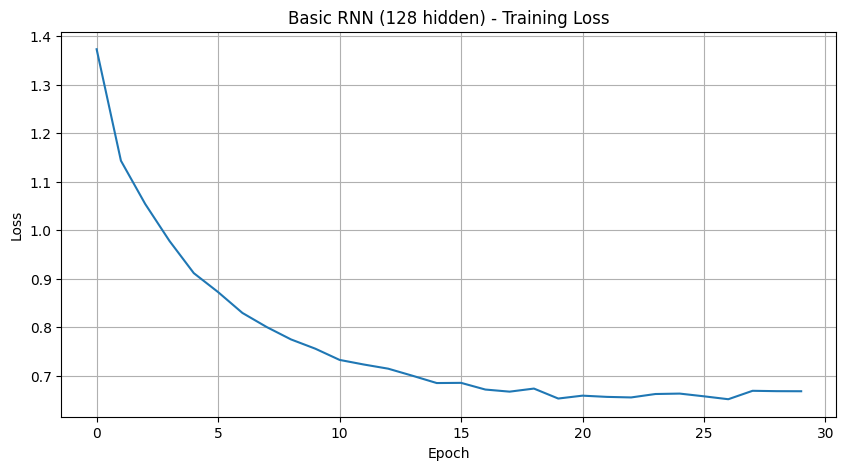


Evaluating Basic RNN (128 hidden)...


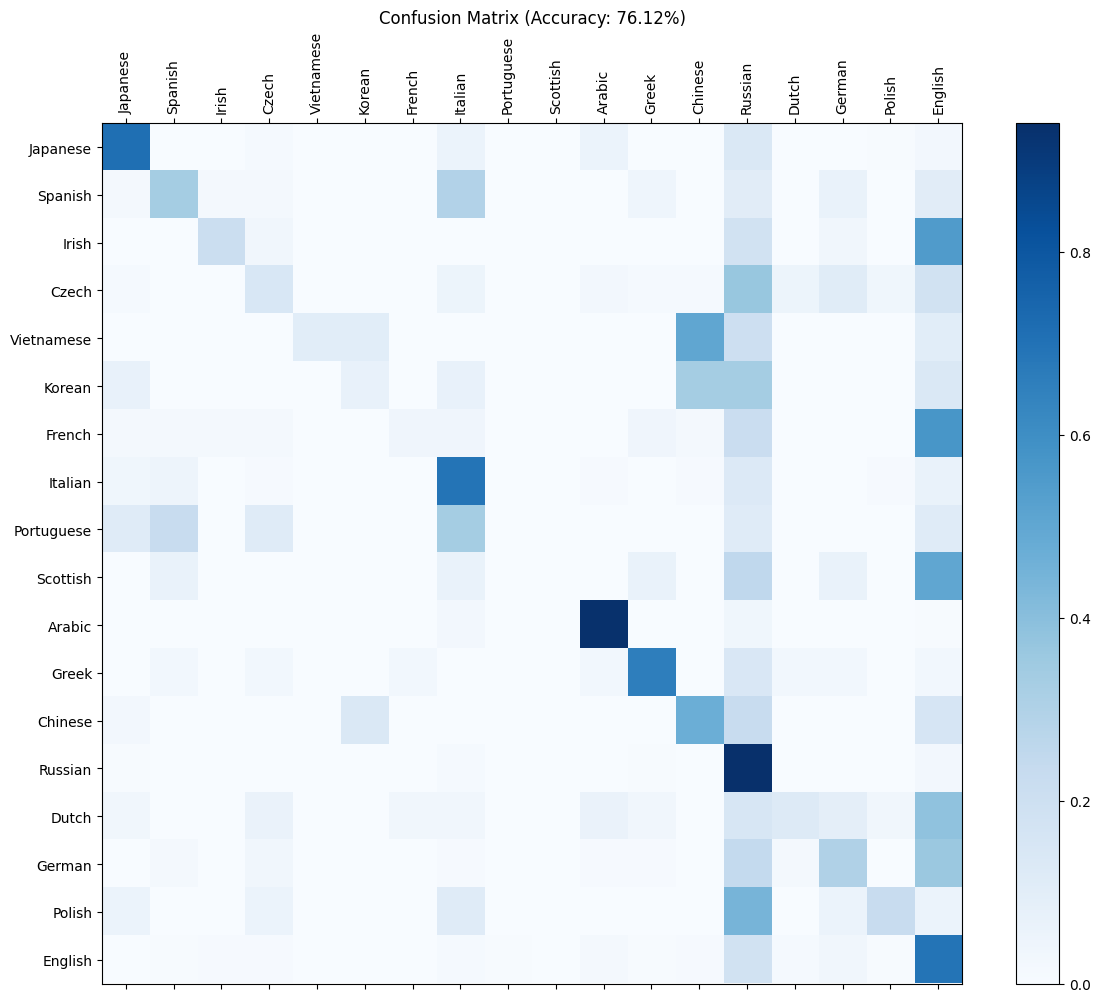

Test Accuracy: 76.12%


In [20]:
# Store results
results: List[Dict[str, any]] = []

# Experiment 1: Basic RNN (Baseline)
print("\n" + "="*60)
print("EXPERIMENT 1: Basic RNN (Baseline)")
print("="*60)
rnn_basic: CharRNN = CharRNN(n_letters, 128, len(alldata.labels_uniq))
result1: Dict[str, any] = run_experiment(
    "Basic RNN (128 hidden)",
    rnn_basic,
    train_set,
    test_set,
    alldata.labels_uniq,
    n_epoch=30,
    learning_rate=0.15
)
results.append(result1)


EXPERIMENT 2: LSTM

Experiment: LSTM (128 hidden)
training on data set with n = 17063
5 (17%): 	 average batch loss = 0.8412
10 (33%): 	 average batch loss = 0.6087
15 (50%): 	 average batch loss = 0.4661
20 (67%): 	 average batch loss = 0.3640
25 (83%): 	 average batch loss = 0.2815
30 (100%): 	 average batch loss = 0.2303
Training took 654.75s


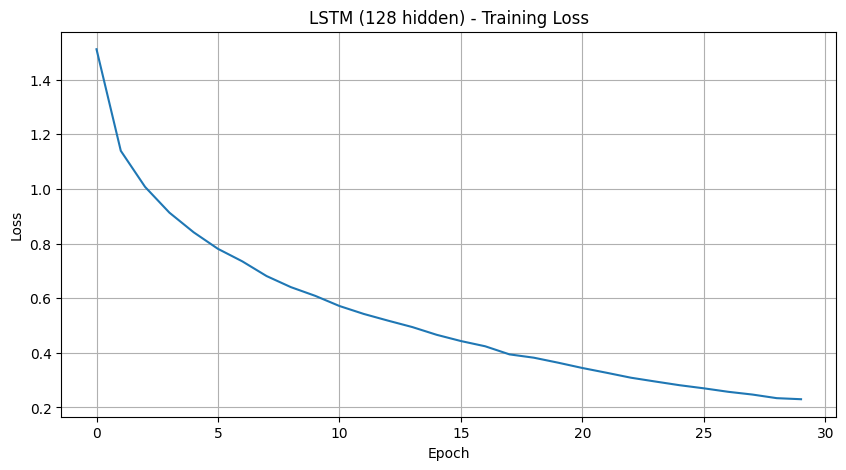


Evaluating LSTM (128 hidden)...


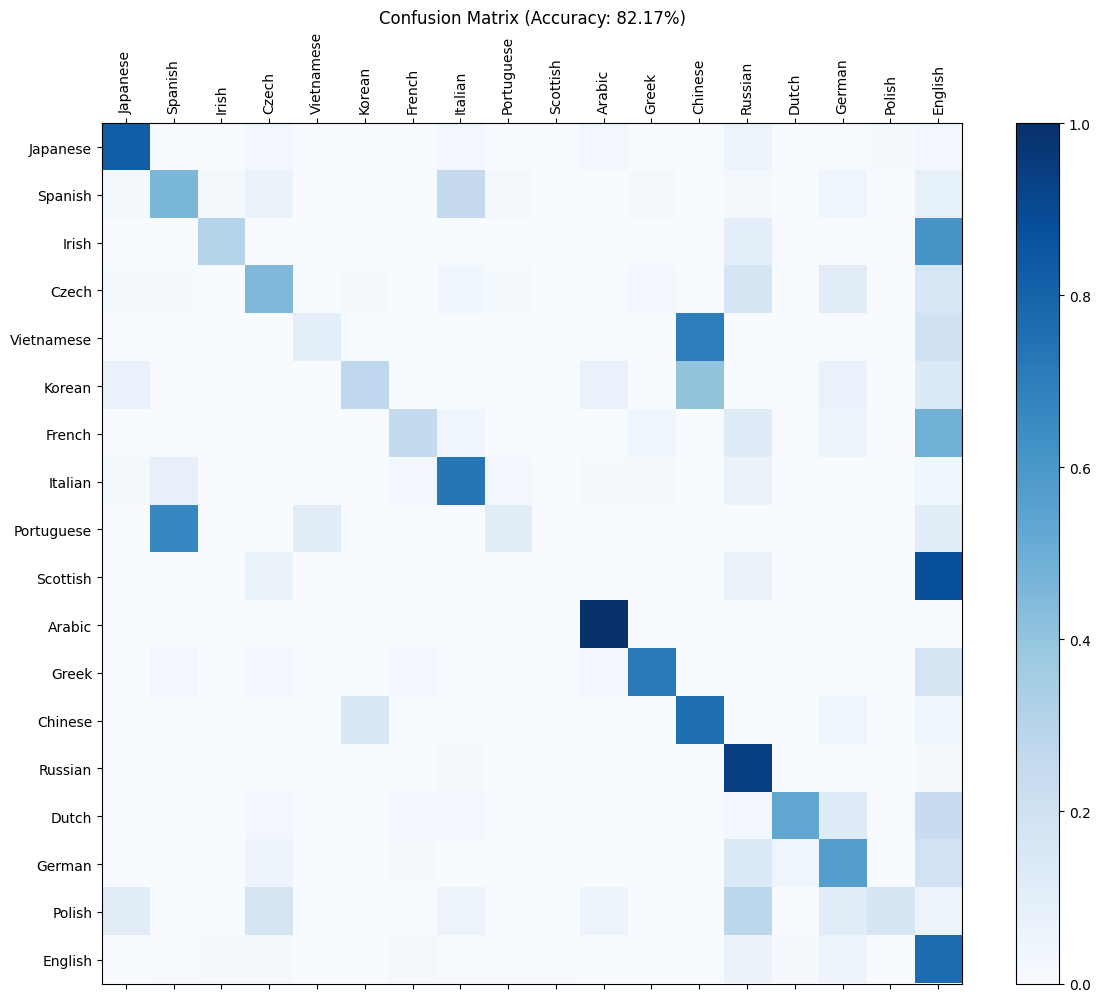

Test Accuracy: 82.17%


In [21]:
# Experiment 2: LSTM
print("\n" + "="*60)
print("EXPERIMENT 2: LSTM")
print("="*60)
lstm: CharLSTM = CharLSTM(n_letters, 128, len(alldata.labels_uniq), dropout=0.2)
result2: Dict[str, any] = run_experiment(
    "LSTM (128 hidden)",
    lstm,
    train_set,
    test_set,
    alldata.labels_uniq,
    n_epoch=30,
    learning_rate=0.15
)
results.append(result2)


EXPERIMENT 3: GRU

Experiment: GRU (128 hidden)
training on data set with n = 17063
5 (17%): 	 average batch loss = 0.7924
10 (33%): 	 average batch loss = 0.5448
15 (50%): 	 average batch loss = 0.3959
20 (67%): 	 average batch loss = 0.2873
25 (83%): 	 average batch loss = 0.2247
30 (100%): 	 average batch loss = 0.1877
Training took 600.45s


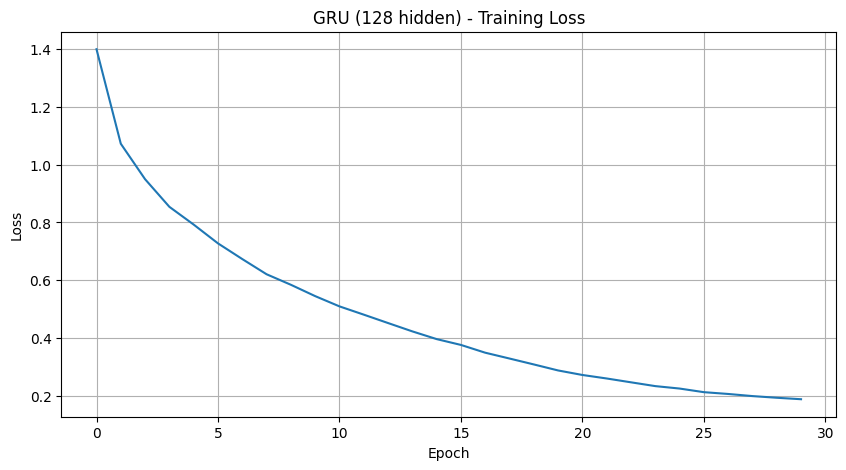


Evaluating GRU (128 hidden)...


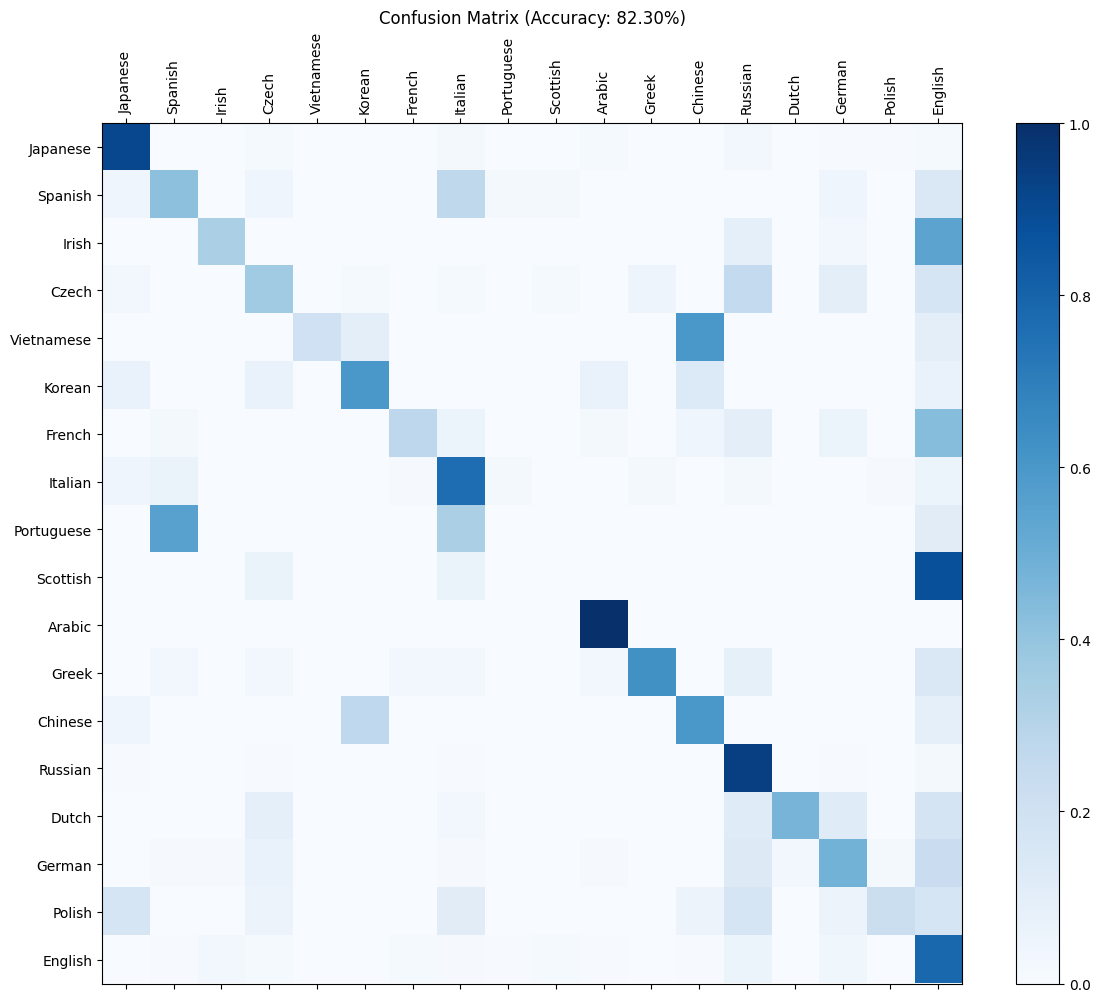

Test Accuracy: 82.30%


In [22]:
# Experiment 3: GRU
print("\n" + "="*60)
print("EXPERIMENT 3: GRU")
print("="*60)
gru: CharGRU = CharGRU(n_letters, 128, len(alldata.labels_uniq), dropout=0.2)
result3: Dict[str, any] = run_experiment(
    "GRU (128 hidden)",
    gru,
    train_set,
    test_set,
    alldata.labels_uniq,
    n_epoch=30,
    learning_rate=0.15
)
results.append(result3)


EXPERIMENT 4: Larger LSTM (256 hidden)

Experiment: LSTM (256 hidden)
training on data set with n = 17063
5 (17%): 	 average batch loss = 0.8718
10 (33%): 	 average batch loss = 0.6313
15 (50%): 	 average batch loss = 0.4817
20 (67%): 	 average batch loss = 0.3557
25 (83%): 	 average batch loss = 0.2602
30 (100%): 	 average batch loss = 0.1995
Training took 775.21s


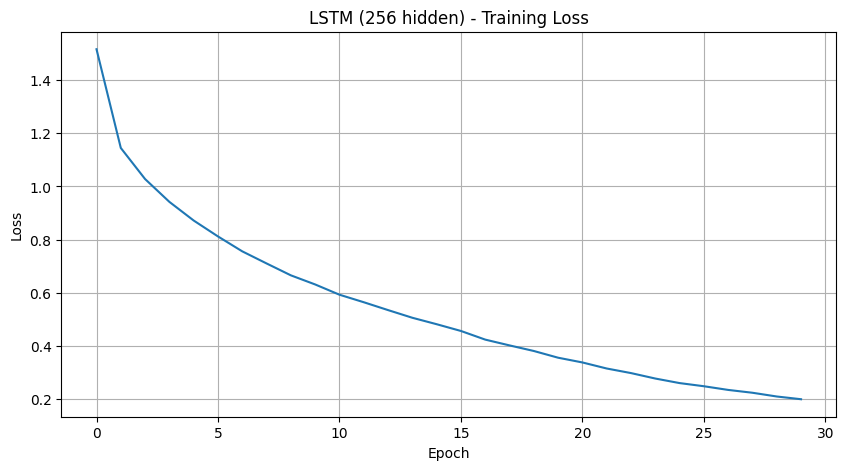


Evaluating LSTM (256 hidden)...


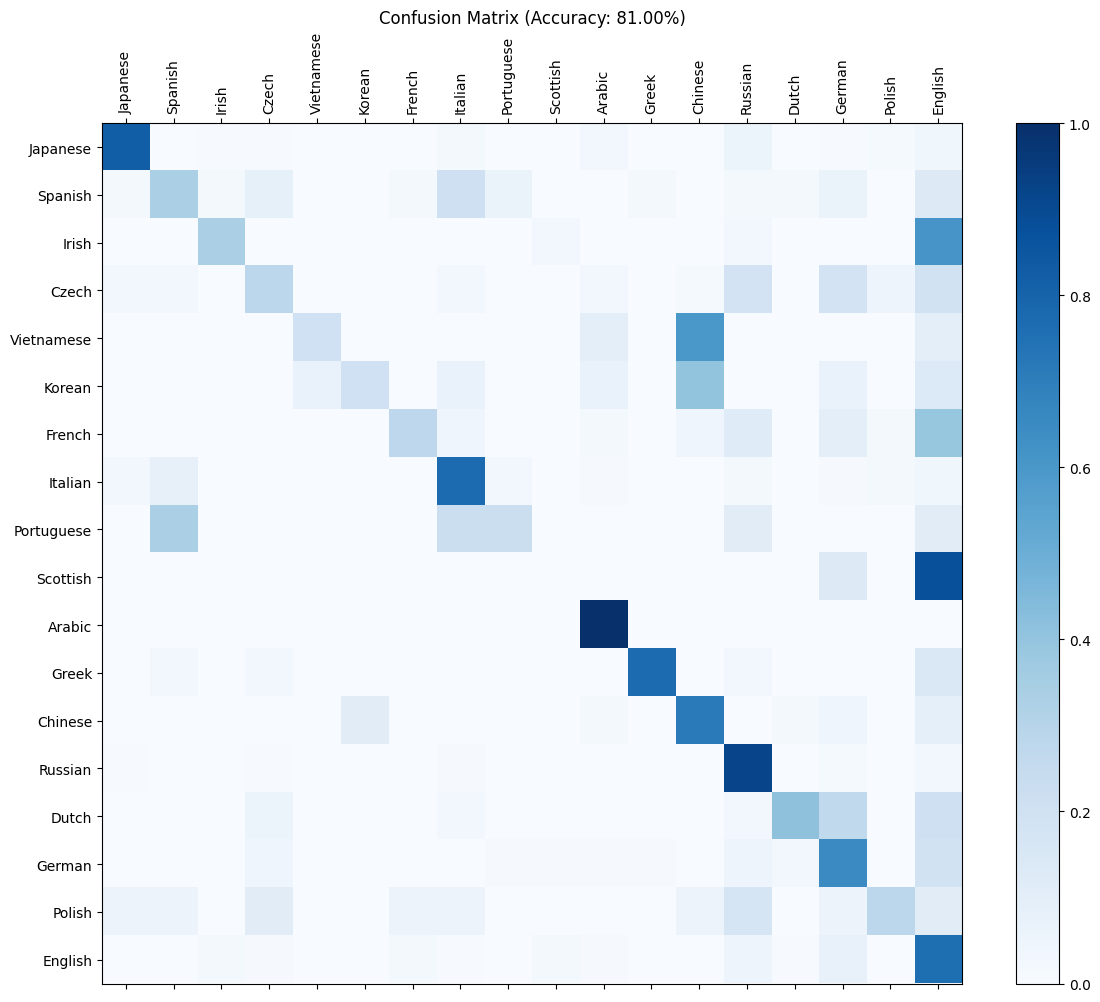

Test Accuracy: 81.00%


In [23]:
# Experiment 4: Larger hidden size
print("\n" + "="*60)
print("EXPERIMENT 4: Larger LSTM (256 hidden)")
print("="*60)
lstm_large: CharLSTM = CharLSTM(n_letters, 256, len(alldata.labels_uniq), dropout=0.2)
result4: Dict[str, any] = run_experiment(
    "LSTM (256 hidden)",
    lstm_large,
    train_set,
    test_set,
    alldata.labels_uniq,
    n_epoch=30,
    learning_rate=0.15
)
results.append(result4)


EXPERIMENT 5: Deep RNN (2 layers)

Experiment: Deep RNN (2 layers, 128 hidden)
training on data set with n = 17063
5 (17%): 	 average batch loss = 0.8973
10 (33%): 	 average batch loss = 0.7608
15 (50%): 	 average batch loss = 0.7162
20 (67%): 	 average batch loss = 0.6979
25 (83%): 	 average batch loss = 0.6797
30 (100%): 	 average batch loss = 0.6740
Training took 751.89s


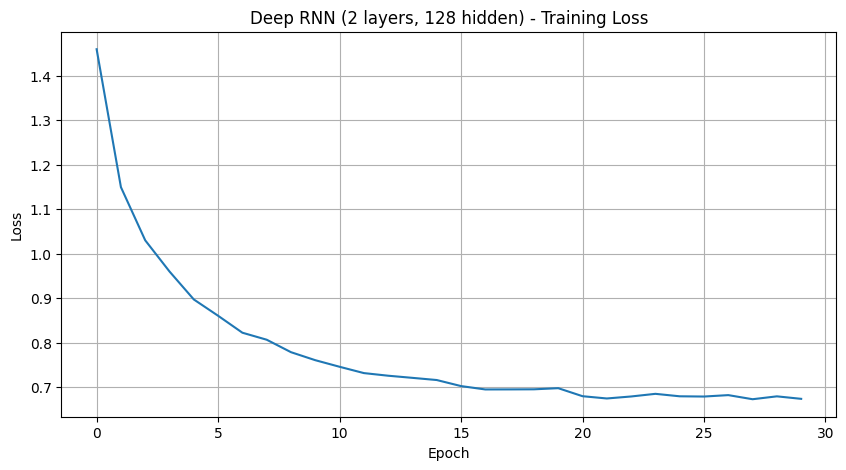


Evaluating Deep RNN (2 layers, 128 hidden)...


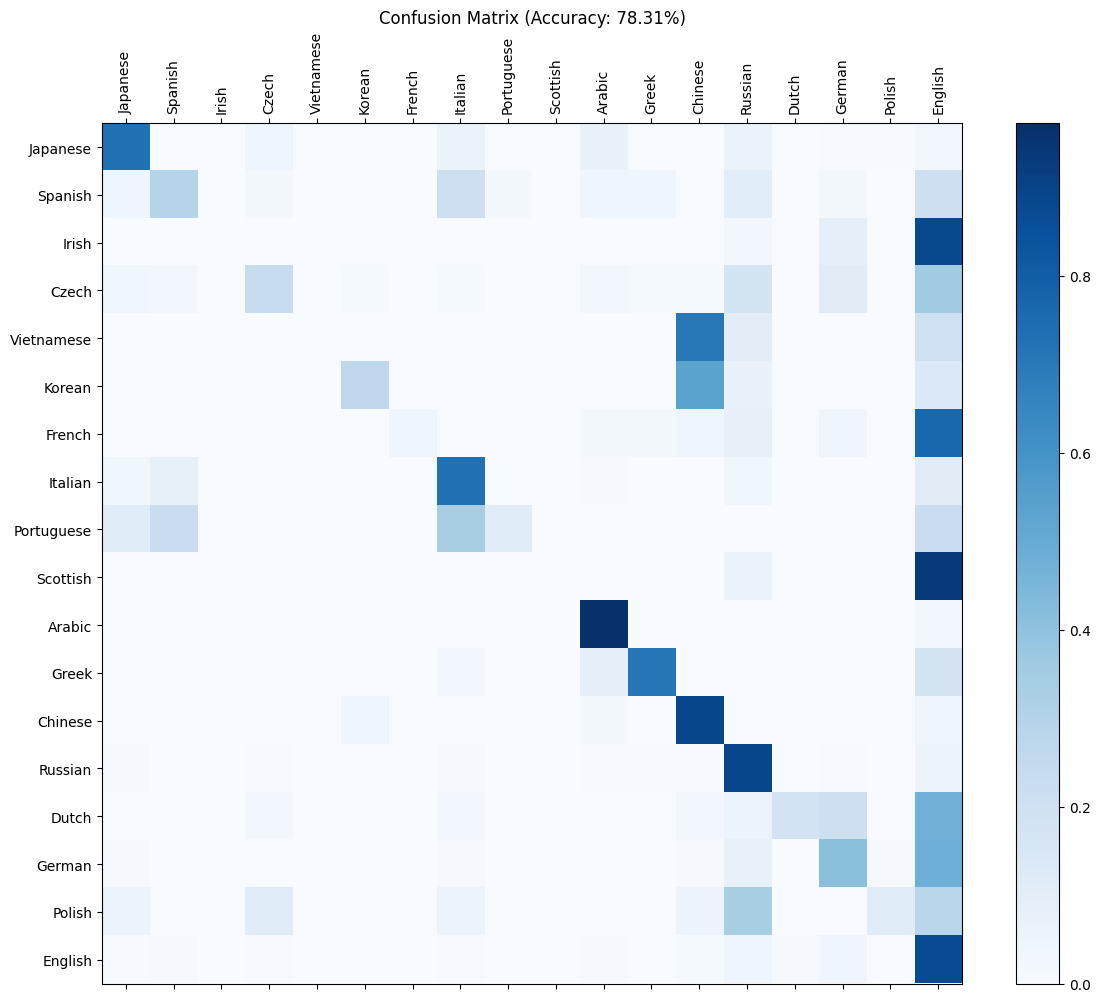

Test Accuracy: 78.31%


In [24]:
# Experiment 5: Deep RNN
print("\n" + "="*60)
print("EXPERIMENT 5: Deep RNN (2 layers)")
print("="*60)
deep_rnn: DeepCharRNN = DeepCharRNN(n_letters, 128, len(alldata.labels_uniq), n_layers=2, dropout=0.2)
result5: Dict[str, any] = run_experiment(
    "Deep RNN (2 layers, 128 hidden)",
    deep_rnn,
    train_set,
    test_set,
    alldata.labels_uniq,
    n_epoch=30,
    learning_rate=0.15
)
results.append(result5)



EXPERIMENT 6: Bidirectional LSTM

Experiment: Bidirectional LSTM (128 hidden)
training on data set with n = 17063
5 (17%): 	 average batch loss = 0.7992
10 (33%): 	 average batch loss = 0.5936
15 (50%): 	 average batch loss = 0.4738
20 (67%): 	 average batch loss = 0.3712
25 (83%): 	 average batch loss = 0.2953
30 (100%): 	 average batch loss = 0.2344
Training took 904.38s


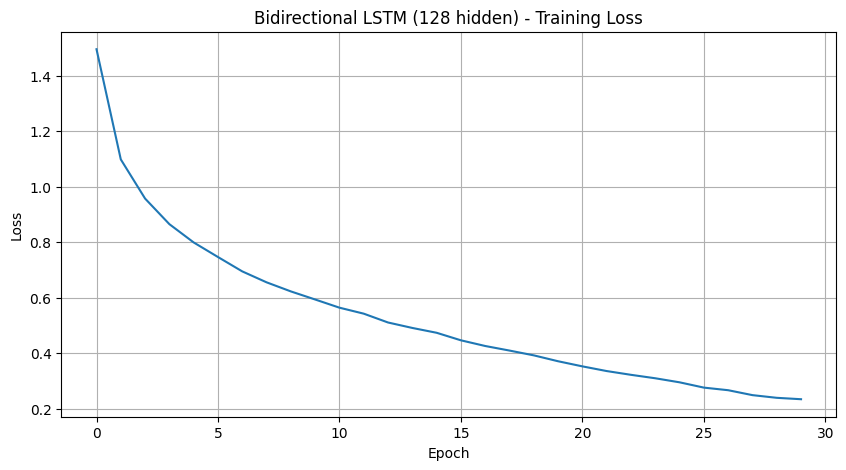


Evaluating Bidirectional LSTM (128 hidden)...


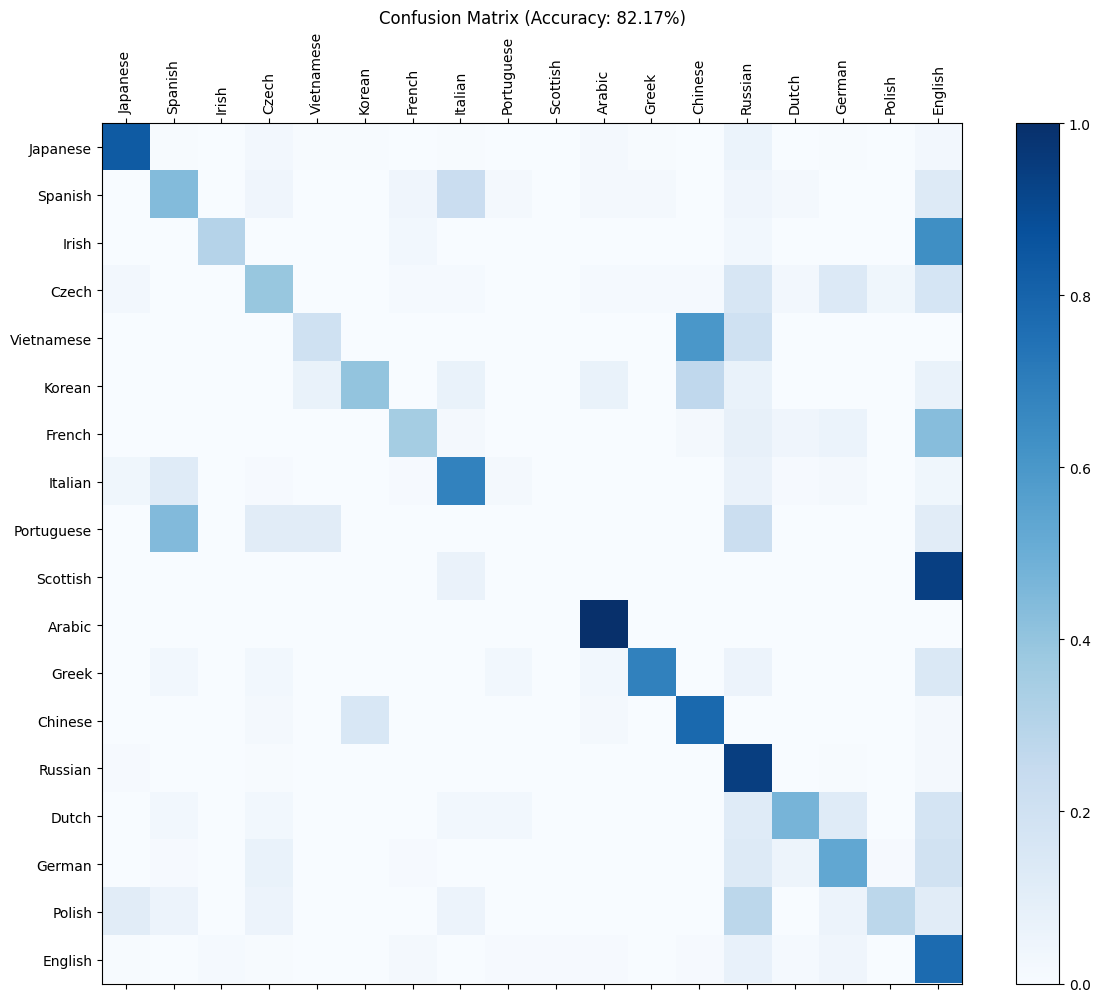

Test Accuracy: 82.17%


In [25]:
# Experiment 6: Bidirectional LSTM
print("\n" + "="*60)
print("EXPERIMENT 6: Bidirectional LSTM")
print("="*60)
bilstm: BiDirectionalCharLSTM = BiDirectionalCharLSTM(n_letters, 128, len(alldata.labels_uniq), dropout=0.2)
result6: Dict[str, any] = run_experiment(
    "Bidirectional LSTM (128 hidden)",
    bilstm,
    train_set,
    test_set,
    alldata.labels_uniq,
    n_epoch=30,
    learning_rate=0.15
)
results.append(result6)


RESULTS SUMMARY

Model                          Accuracy     Training Time  
------------------------------------------------------------
GRU (128 hidden)               82.30%       600.45         s
LSTM (128 hidden)              82.17%       654.75         s
Bidirectional LSTM (128 hidden) 82.17%       904.38         s
LSTM (256 hidden)              81.00%       775.21         s
Deep RNN (2 layers, 128 hidden) 78.31%       751.89         s
Basic RNN (128 hidden)         76.12%       497.18         s


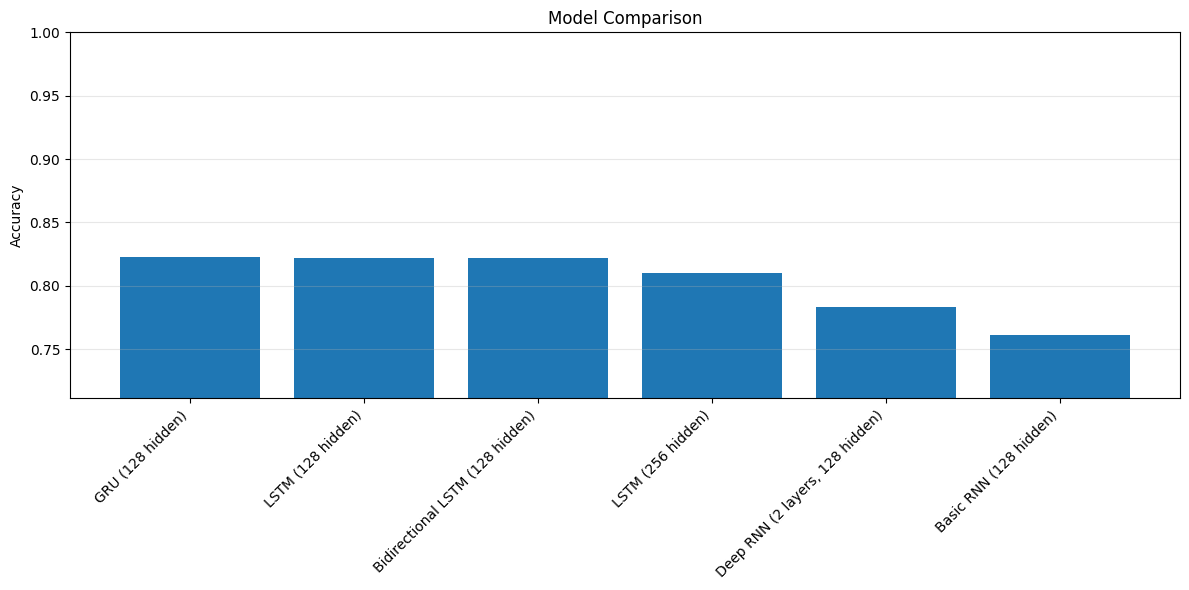


Best Model: GRU (128 hidden)
Best Accuracy: 82.30%


In [26]:
# ===============================
# RESULTS SUMMARY
# ===============================

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

# Sort by accuracy
results.sort(key=lambda x: x['metrics']['accuracy'], reverse=True)

print(f"\n{'Model':<30} {'Accuracy':<12} {'Training Time':<15}")
print("-" * 60)
for result in results:
    print(f"{result['model_name']:<30} {result['metrics']['accuracy']:<12.2%} {result['training_time']:<15.2f}s")

# Plot comparison
plt.figure(figsize=(12, 6))
model_names: List[str] = [r['model_name'] for r in results]
accuracies: List[float] = [r['metrics']['accuracy'] for r in results]

plt.bar(range(len(model_names)), accuracies)
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim([min(accuracies) - 0.05, 1.0])
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

print("\nBest Model:", results[0]['model_name'])
print(f"Best Accuracy: {results[0]['metrics']['accuracy']:.2%}")